# FareCast NYC: Empowering TLC Riders with Fare Estimation

## Overview

**Executive Summary:**

Automatidata, a fictional data consulting firm, is collaborating with the New York City Taxi and Limousine Commission (TLC). Since its establishment in 1971, the TLC has been responsible for regulating and overseeing the licensing of various transportation services in New York City, including taxi cabs, for-hire vehicles, commuter vans, and paratransit vehicles <sup>[1]</sup>. The TLC envisions the development of a user-friendly app, and in partnership with Automatidata, aims to enhance the overall experience for TLC riders by providing the ability to estimate taxi fares in advance.

This initiative aligns seamlessly with Automatidata's mission to transform untapped and stored data into practical solutions. Leveraging the extensive NYC TLC dataset, our goal is to craft a robust regression model that accurately estimates taxi fares, offering transparency and convenience to riders. The FareCast NYC app aspires to not only address the business needs of the TLC but also strategically impact the transportation landscape by improving transparency in fare calculations.

For more information about the TLC, visit their official page: [About TLC](https://www.nyc.gov/site/tlc/about/about-tlc.page).

**Project Objectives:**

1. Develop a robust fare estimation model:
    - Utilise historical data from the NYC TLC dataset to construct a reliable regression model for accurately estimating taxi fares.
    
    
2. Ensure accuracy and reliability:
    * Implement rigorous testing and optimization procedures to guarantee the precision and dependability of fare estimates generated by the model.


3. Create a user-friendly app interface:
    * Design an intuitive app interface tailored for TLC riders, facilitating easy and efficient estimation of taxi fares.


4. Enhance user satisfaction and confidence:
    * Improve overall user satisfaction and instil confidence in NYC taxi services by providing transparent and trustworthy fare estimation through the developed app.

**Data Sources:**

The primary data source for this project is the "2017 Yellow Taxi Trip Data", available on NYC OpenData. This dataset contains information on taxi and for-hire vehicle trips, with 22,699 rows and 18 columns.

For a detailed description of each attribute and its meaning, please refer to the [Data Dictionary](https://github.com/sssunri/farecast_NYC-TLC_estimation/blob/main/data_dictionary_trip_records_yellow.pdf) provided by the New York City Taxi & Limousine Commission. Leveraging this rich data dictionary, we will gain a comprehensive understanding of the dataset, which is crucial for building a robust fare estimation model.

## Data Exploration

**Load the Data**

In [1]:
# import libraries and packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

plt.rcParams['figure.figsize'] = 15, 5
pd.set_option('display.max_columns', None)

In [2]:
# load dataset into dataframe
df = pd.read_csv('data/2017_Yellow_Taxi_Trip_Data.csv')

**Initial Exploration**

In [3]:
df.head()

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,24870114,2,03/25/2017 8:55:43 AM,03/25/2017 9:09:47 AM,6,3.34,1,N,100,231,1,13.0,0.0,0.5,2.76,0.0,0.3,16.56
1,35634249,1,04/11/2017 2:53:28 PM,04/11/2017 3:19:58 PM,1,1.80,1,N,186,43,1,16.0,0.0,0.5,4.00,0.0,0.3,20.80
2,106203690,1,12/15/2017 7:26:56 AM,12/15/2017 7:34:08 AM,1,1.00,1,N,262,236,1,6.5,0.0,0.5,1.45,0.0,0.3,8.75
3,38942136,2,05/07/2017 1:17:59 PM,05/07/2017 1:48:14 PM,1,3.70,1,N,188,97,1,20.5,0.0,0.5,6.39,0.0,0.3,27.69
4,30841670,2,04/15/2017 11:32:20 PM,04/15/2017 11:49:03 PM,1,4.37,1,N,4,112,2,16.5,0.5,0.5,0.00,0.0,0.3,17.80


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22699 entries, 0 to 22698
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             22699 non-null  int64  
 1   VendorID               22699 non-null  int64  
 2   tpep_pickup_datetime   22699 non-null  object 
 3   tpep_dropoff_datetime  22699 non-null  object 
 4   passenger_count        22699 non-null  int64  
 5   trip_distance          22699 non-null  float64
 6   RatecodeID             22699 non-null  int64  
 7   store_and_fwd_flag     22699 non-null  object 
 8   PULocationID           22699 non-null  int64  
 9   DOLocationID           22699 non-null  int64  
 10  payment_type           22699 non-null  int64  
 11  fare_amount            22699 non-null  float64
 12  extra                  22699 non-null  float64
 13  mta_tax                22699 non-null  float64
 14  tip_amount             22699 non-null  float64
 15  to

The data types are generally appropriate for most columns. `tpep_pickup_datetime` and `tpep_dropoff_datetime` contain datetime information for the pickup and dropoff times. Converting these columns to `datetime` objects will facilitate the extraction of additional time-based features for future analysis and model training. This step ensures consistency and enables more straightforward date-based analysis.

All columns have non-null counts matching the total number of entries (22,699), indicating the absence of missing values. Several key attributes are likely to influence fare amounts, such as `trip_distance`, `passenger_count`, `payment_type`, and datetime features. The column `Unnamed: 0` appears to be redundant, possibly representing an old index. Removing it will enhance the clarity and efficiency of the dataset.

In [5]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,22699.0,5.675849e+07,3.274493e+07,12127.0,28520556.00,56731504.00,85374524.00,1.134863e+08
VendorID,22699.0,1.556236e+00,4.968384e-01,1.0,1.00,2.00,2.00,2.000000e+00
passenger_count,22699.0,1.642319e+00,1.285231e+00,0.0,1.00,1.00,2.00,6.000000e+00
trip_distance,22699.0,2.913313e+00,3.653171e+00,0.0,0.99,1.61,3.06,3.396000e+01
RatecodeID,22699.0,1.043394e+00,7.083909e-01,1.0,1.00,1.00,1.00,9.900000e+01
PULocationID,22699.0,1.624124e+02,6.663337e+01,1.0,114.00,162.00,233.00,2.650000e+02
DOLocationID,22699.0,1.615280e+02,7.013969e+01,1.0,112.00,162.00,233.00,2.650000e+02
payment_type,22699.0,1.336887e+00,4.962111e-01,1.0,1.00,1.00,2.00,4.000000e+00
fare_amount,22699.0,1.302663e+01,1.324379e+01,-120.0,6.50,9.50,14.50,9.999900e+02
extra,22699.0,3.332746e-01,4.630966e-01,-1.0,0.00,0.00,0.50,4.500000e+00


The descriptive statistics reveal a dataset with diverse numeric features exhibiting wide-ranging values, suggesting the importance of careful consideration during analysis. The majority of trips involve one to two passengers, occasionally reaching a maximum of six. Payments are predominantly made via credit card (payment type 1). The average trip distance is approximately 2.91 miles, and rate codes vary, with the majority falling under code 1. 

Notably, certain columns demonstrate considerable variability, potentially influencing specific analyses. For instance, the presence of a minimum passenger count of 0 prompts further investigation, as does the identification of negative values in `fare_amount`, demanding closer scrutiny. Additionally, related columns such as `tip_amount` and `total_amount` exhibit maximum values that appear as outliers. Recognizing the potential influence of outliers on statistical analyses, it is essential to subject them to further scrutiny. These findings underscore the need for a comprehensive exploratory data analysis (EDA) to gain a deeper understanding of the data distribution and identify and handle potential outliers effectively.

## Data Cleaning and Preprocessing

### Dealing with Duplicates

In [6]:
df.duplicated().sum()

0

The assessment for duplicate rows, conducted through df.duplicated().sum(), resulted in a count of 0, signifying the absence of duplicate entries in the dataset. This outcome reinforces the integrity of the data, affirming that each row distinctly represents a unique taxi trip. The absence of duplicates enhances the reliability of our analysis, providing a solid foundation for subsequent exploration and modeling efforts.

### Date and Time Parsing

The conversion of the date and time columns to `datetime` objects is performed to facilitate easier manipulation of temporal information. This transformation enables more straightforward analyses involving time-based features. Subsequently, we will extract pertinent temporal features, such as the day of the week or hour of the day, to deepen our understanding of the temporal patterns within the dataset. This step is pivotal for enhancing the model's ability to discern variations in taxi fares based on specific time-related factors, contributing to the overall robustness of our analytical approach.

In [7]:
df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
df['tpep_pickup_datetime'].head()

0   2017-03-25 08:55:43
1   2017-04-11 14:53:28
2   2017-12-15 07:26:56
3   2017-05-07 13:17:59
4   2017-04-15 23:32:20
Name: tpep_pickup_datetime, dtype: datetime64[ns]

In [8]:
df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'])
df['tpep_dropoff_datetime'].head()

0   2017-03-25 09:09:47
1   2017-04-11 15:19:58
2   2017-12-15 07:34:08
3   2017-05-07 13:48:14
4   2017-04-15 23:49:03
Name: tpep_dropoff_datetime, dtype: datetime64[ns]

### Handling Redundant Columns

The column labeled `Unnamed: 0` appears to be an index or identifier, and its role in the dataset is not explicitly defined. Given its potentially redundant nature, we will streamline the dataset by removing this column.

In [9]:
df.drop(columns='Unnamed: 0', inplace=True)

In [10]:
df['mta_tax'].value_counts()

 0.5    22596
 0.0       90
-0.5       13
Name: mta_tax, dtype: int64

The `mta_tax` column signifies a \\$0.50 MTA tax automatically triggered based on the metered rate in use. However, upon examining its distribution, we observe minimal variability, with the majority of values consistently set at \\$0.50. Given this limited variability and after careful consideration of its relevance to fare estimation, we have decided to remove the `mta_tax` column. The tax does not emerge as a critical factor in understanding or predicting fare amounts, and its presence may not significantly enhance the depth of our analysis.

In [11]:
df['improvement_surcharge'].value_counts()

 0.3    22679
-0.3       14
 0.0        6
Name: improvement_surcharge, dtype: int64

According to the data dictionary, the `improvement_surcharge` column denotes a \\$0.30 improvement surcharge assessed on trips at the flag drop, a practice initiated in 2015. However, upon examining its distribution, it becomes evident that the majority of values consistently remain at \\$0.30. With only a few instances of variation, the column's contribution to the analysis may be limited. Therefore, we have decided to remove the `improvement_surcharge` column as it is not deemed a critical factor in understanding or predicting fare amounts.

In [12]:
df.drop(columns=['mta_tax', 'improvement_surcharge'], inplace=True)

### Dealing with Outliers

Utilizing boxplots, we aim to gain a comprehensive understanding of the distribution of each feature within our dataset. These visualizations present a clear summary, showcasing key statistics such as the median, quartiles, and highlighting potential outliers. By visually inspecting the distribution of each variable, we can efficiently identify and assess the presence of any potential outliers, providing valuable insights for subsequent analysis and decision-making.

Given the relatively small size of our dataset, it is less likely that we will delete outliers. To address potential errors, our approach involves reassigning outliers by deriving new values to replace the outlier values. Alternatively, for the purpose of exploratory data analysis (without utilizing them in machine learning models), we will leave the outliers unchanged.

In [13]:
def boxplot(feature):
    sns.boxplot(data=df, x=feature)
    plt.title(f"Detect Outliers: {feature.title().replace('_', ' ')}")
    plt.show() 

In [14]:
def histplot(feature, **kwargs):
    sns.histplot(data=df, x=feature, **kwargs)
    plt.title(f"{feature.title().replace('_', ' ')}")
    plt.show()

**Trip Distance**

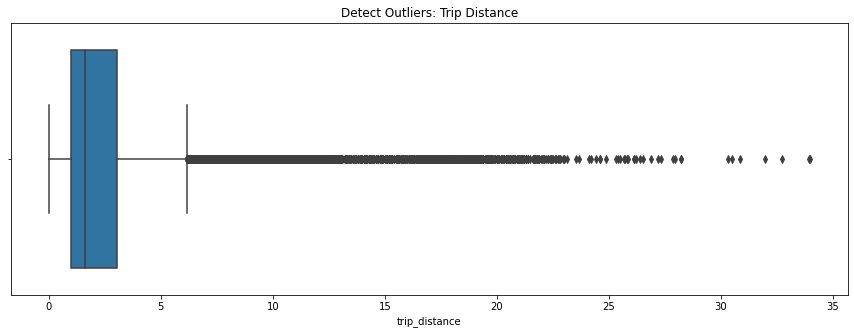

In [15]:
boxplot(feature='trip_distance')

The box plot analysis of trip distance reveals the presence of outliers; however, it is important to note that these outliers fall within a reasonable range for taxi trips in New York City, extending up to 35 miles. Given the nature of urban transportation in New York City, where taxi rides can cover varying distances, the observed outliers are considered normal and reflective of the diverse trip characteristics within the city. However, the analysis revealed some trips with a distance of zero, prompting further investigation into the smallest 10 unique trips.

In [16]:
set(df['trip_distance'].sort_values().unique()[:10])

{0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09}

In [17]:
(len(df[df['trip_distance'] == 0]) / len(df)) * 100

0.6520111018106525

The distances, captured with a high degree of precision, include values such as 0.01, 0.02, and so on. While it might seem unusual for trips to have distances of zero, this could be attributed to scenarios where a passenger summoned a taxi and subsequently changed their mind. Only a small percentage (<1%) of trips have zero miles traveled. Considering the negligible impact on the overall dataset, we have decided to retain these outliers in our analysis. This decision ensures that our data analysis accurately reflects the diverse characteristics of taxi trips in the city and provides a robust foundation for the FareCast NYC app's development.

**Fare Amount**

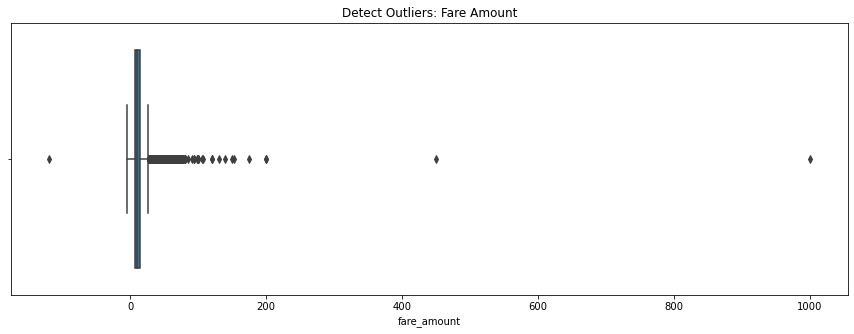

In [18]:
boxplot(feature='fare_amount')

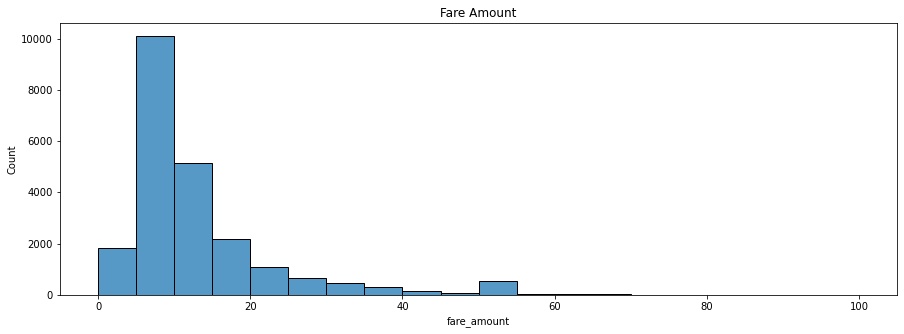

In [19]:
histplot(feature='fare_amount', bins=range(0, 101, 5))

In [20]:
df.describe()['fare_amount']

count    22699.000000
mean        13.026629
std         13.243791
min       -120.000000
25%          6.500000
50%          9.500000
75%         14.500000
max        999.990000
Name: fare_amount, dtype: float64

Analyzing the fare distribution histogram reveals a right-skewed distribution, with the majority of trip costs falling between \\$5 and \\$15. However, a detailed examination of total fare amounts identifies outliers that deviate significantly from this typical distribution. Notably, there are instances with a negative value of -\\$120 and extreme positive values, reaching as high as \\$1,000. These outliers, considered unusual, have the potential to introduce noise into our analysis.

Our commitment to providing transparent and accurate fare estimates through the FareCast NYC app necessitates the careful treatment of outliers. By addressing these extreme values, we aim to enhance the precision of our model and provide users with reliable fare estimates that align with the typical fare distribution observed in New York City taxi trips. This proactive approach ensures that the fare estimation process is robust and reflective of the expected fare amounts in the NYC transportation landscape.

In [21]:
q3 = df['fare_amount'].quantile(0.75)
iqr = q3 - df['fare_amount'].quantile(0.25)
iqr

8.0

In [22]:
upper_threshold = q3 + (1.5 * iqr)
upper_threshold

26.5

The interquartile range (IQR) for this feature was calculated, yielding a value of \\$8. However, the standard formula for outlier identification `(Q3 + 1.5 * IQR)` suggested a threshold of \\$26.50, which seemed inappropriate for a maximum fare cap. In this context, we opted for a more nuanced approach, using a factor of `6` to impute the upper-limit value. Additionally, any fare amounts less than \\$0 were imputed with 0 to maintain consistency.

In [23]:
def outlier_imputer(column_list, iqr_factor):
    '''
    Impute upper-limit values in specified columns based on their interquartile range.

    Arguments:
        column_list: A list of columns to iterate over
        iqr_factor: A number representing x in the formula:
                    Q3 + (x * IQR). Used to determine maximum threshold,
                    beyond which a point is considered an outlier.

    The IQR is computed for each column in column_list and values exceeding
    the upper threshold for each column are imputed with the upper threshold value.
    '''
    # reassign minimum to zero
    for i in column_list:
        df.loc[df[i] < 0, i] = 0

        # calculate upper threshold
        q3 = df[i].quantile(0.75)
        iqr = q3 - df[i].quantile(0.25)
        upper_threshold = q3 + (iqr_factor * iqr)

        # reassign values > threshold to threshold
        df.loc[df[i] > upper_threshold, i] = upper_threshold
        print(f'[{i}] q3: {q3}, upper threshold: {upper_threshold}')
        print(df[i].describe())

In [24]:
outlier_imputer(['fare_amount'], 6)

[fare_amount] q3: 14.5, upper threshold: 62.5
count    22699.000000
mean        12.897913
std         10.541137
min          0.000000
25%          6.500000
50%          9.500000
75%         14.500000
max         62.500000
Name: fare_amount, dtype: float64


The resulting `fare_amount` column underwent a transformation, with values exceeding the new upper threshold of \\$62.50 capped at this limit. This approach ensures a balanced treatment of extreme values, enhancing the reliability of our analysis. The impact of this imputation strategy is reflected in the updated statistics, where the maximum fare is now capped at \\$62.50, aligning with the characteristics of taxi fare distribution in New York City.

**Tip Amount**

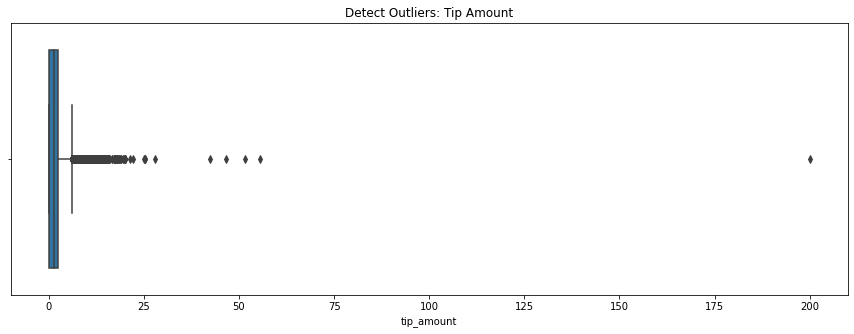

In [25]:
boxplot(feature='tip_amount')

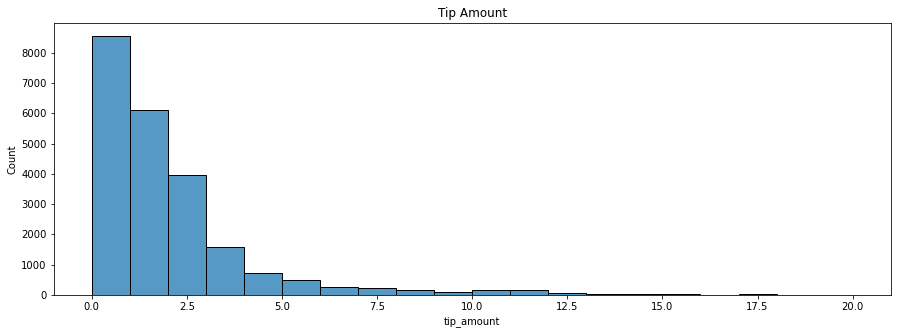

In [26]:
histplot(feature='tip_amount', bins=range(0, 21))

In [27]:
df.describe()['tip_amount']

count    22699.000000
mean         1.835781
std          2.800626
min          0.000000
25%          0.000000
50%          1.350000
75%          2.450000
max        200.000000
Name: tip_amount, dtype: float64

The distribution of tip amounts is right-skewed, with nearly all tips falling within the \\$0 to \\$3 range.

In [28]:
q3 = df['tip_amount'].quantile(0.75)
iqr = q3 - df['tip_amount'].quantile(0.25)
iqr

2.45

In [29]:
upper_threshold = q3 + (6 * iqr)
upper_threshold

17.150000000000002

In [30]:
outlier_imputer(['tip_amount'], 6)

[tip_amount] q3: 2.45, upper threshold: 17.150000000000002
count    22699.000000
mean         1.818543
std          2.374812
min          0.000000
25%          0.000000
50%          1.350000
75%          2.450000
max         17.150000
Name: tip_amount, dtype: float64


The `tip_amount` column exhibits a right-skewed distribution, as evident from its histogram, with the majority of tips falling within the \\$0 to \\$3 range. However, there are notable outliers, particularly in the range of \\$45 to \\$200, which deviate significantly from the typical distribution. To address this, we will apply a similar outlier imputation strategy as employed for the `fare_amount` column. The descriptive statistics reveal a mean tip amount of \\$1.83, with a standard deviation of \\$2.80, while the minimum and maximum values are \\$0 and \\$200, respectively. By calculating the interquartile range (IQR) and employing a factor of `6`, we determine a new upper threshold of \\$17.15. This approach ensures that extreme tip amounts are capped at a reasonable level, aligning with the expected distribution of tips in the context of taxi rides in New York City. 

## Feature Engineering

**Temporal Features**

In [31]:
# create a month column
df['month'] = df['tpep_pickup_datetime'].dt.month_name()
df['month'].head()

0       March
1       April
2    December
3         May
4       April
Name: month, dtype: object

In [32]:
# create a day of week column
df['day'] = df['tpep_pickup_datetime'].dt.day_name()
df['day'].head()

0    Saturday
1     Tuesday
2      Friday
3      Sunday
4    Saturday
Name: day, dtype: object

In [33]:
# create an hour column
df['hour'] = df['tpep_pickup_datetime'].dt.hour
df['hour'].head()

0     8
1    14
2     7
3    13
4    23
Name: hour, dtype: int64

**Time of Day**

We will introduce a `time_of_day` column, categorizing each trip based on the pickup time into specific periods:
- `am_rush`: 06:00 – 10:00
- `daytime`: 10:00 – 16:00
- `pm_rush`: 16:00 – 20:00
- `nighttime`: 20:00 – 06:00

In [34]:
df['time_of_day'] = df['hour'].copy()
for i in df['time_of_day']:
    if (i >= 6) & (i < 10):
        df['time_of_day'] = df['time_of_day'].replace(i, 'am_rush')
    elif (i >= 10) & (i < 16):
        df['time_of_day'] = df['time_of_day'].replace(i, 'daytime')
    elif (i >= 16) & (i < 20):
        df['time_of_day'] = df['time_of_day'].replace(i, 'pm_rush')
    else:
        df['time_of_day'] = df['time_of_day'].replace(i, 'nighttime')

In [35]:
df[['tpep_pickup_datetime', 'time_of_day']].head()

,tpep_pickup_datetime,time_of_day
0,2017-03-25 08:55:43,am_rush
1,2017-04-11 14:53:28,daytime
2,2017-12-15 07:26:56,am_rush
3,2017-05-07 13:17:59,daytime
4,2017-04-15 23:32:20,nighttime


**Transaction Season** 

We are introducing the `season` feature that categorizes each transaction based on the season in which it occurred. This addition will provide valuable insights into the temporal distribution of taxi trips, allowing for more nuanced analyses and predictions. This enhancement aims to capture seasonal patterns and variations in taxi usage, contributing to a more comprehensive understanding of the factors influencing fare amounts.

In [36]:
# https://stackoverflow.com/questions/44124436/python-datetime-to-season
# https://seasonsyear.com/USA/New-York/NYC  
df['season'] = df['tpep_pickup_datetime'].dt.month % 12 // 3 + 1
df[['season', 'month']]

,season,month
0,2,March
1,2,April
2,1,December
3,2,May
4,2,April
...,...,...
22694,1,February
22695,3,August
22696,4,September
22697,3,July


**Trip Duration**

In [37]:
# create duration column in minutes
df['duration'] = round((df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']) / np.timedelta64(1, 'm'), 2)
df['duration'].head()

0    14.07
1    26.50
2     7.20
3    30.25
4    16.72
Name: duration, dtype: float64

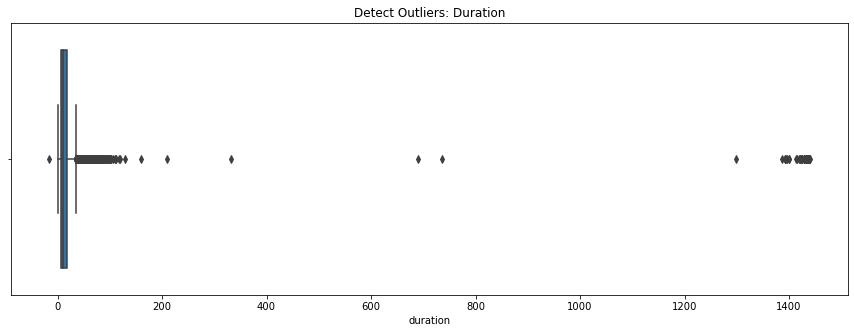

In [38]:
boxplot('duration')

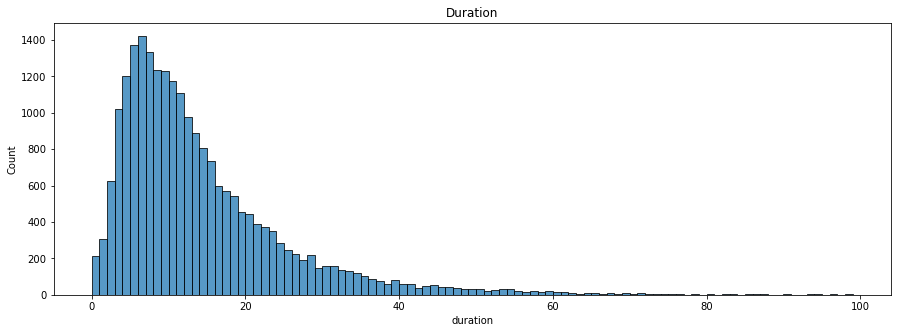

In [39]:
histplot(feature='duration', bins=range(0, 100))

In [40]:
df.describe()['duration']

count    22699.000000
mean        17.013766
std         61.996476
min        -16.980000
25%          6.650000
50%         11.180000
75%         18.380000
max       1439.550000
Name: duration, dtype: float64

In [41]:
outlier_imputer(['duration'], 6)

[duration] q3: 18.38, upper threshold: 88.75999999999999
count    22699.000000
mean        14.460471
std         11.946570
min          0.000000
25%          6.650000
50%         11.180000
75%         18.380000
max         88.760000
Name: duration, dtype: float64


The `duration` column, representing the duration of taxi trips, exhibits a right-skewed distribution, as observed from the histogram. The descriptive statistics highlight a mean duration of approximately 17 minutes, with a standard deviation of 61.99 minutes. However, an analysis of the boxplot reveals the presence of outliers, both below 0 and beyond 200 minutes. Outliers below 0 may be indicative of data entry errors, while extremely long durations could be attributed to specific circumstances or anomalies. To ensure the integrity of our analysis and provide users with realistic estimates, we will apply the outlier imputation strategy, determining new upper and lower thresholds for the `duration` column. This approach aims to cap extreme values, maintaining the overall accuracy of our analysis and aligning with the expected distribution of trip durations in the context of New York City taxi rides.

**Mean Trip Distance and Duration**

In anticipation of real-time predictions where the model will not have access to trip duration until after completion, we are proactively enhancing our dataset with new features. Specifically, we are introducing `mean_distance` and `mean_duration` based on pick-up and drop-off locations. These features leverage historical trip data to capture patterns and characteristics associated with specific areas. To begin, we will group and average trips that share a unique pair of start and end points together.

In [42]:
pickup, dropoff, pickup_dropoff = ([] for i in range(3))
for i in range(len(df)): 
    pickup.append(str(df['PULocationID'][i]))
    dropoff.append(str(df['DOLocationID'][i]))
    pickup_dropoff.append(f'{pickup[i]} {dropoff[i]}')
df['pickup_dropoff'] = pickup_dropoff
df['pickup_dropoff'].head()

0    100 231
1     186 43
2    262 236
3     188 97
4      4 112
Name: pickup_dropoff, dtype: object

**Mean Distance**

The `mean_distance` feature aggregates historical trip distances for each pick-up and drop-off location, offering valuable insights into the average distances travelers cover in those areas. This will enable our model to discern typical travel patterns and distances for different locations, enhancing its ability to predict future trips. 

In [43]:
# group unique pairs and aggregate trip distance average
grouped = df.groupby(by='pickup_dropoff').mean()[['trip_distance']]
grouped.head()

,trip_distance
pickup_dropoff,
1 1,2.433333
10 148,15.700000
100 1,16.890000
100 100,0.253333
100 107,1.180000


In [44]:
grouped_dict = grouped.to_dict()
for k, v in grouped_dict.items():
    grouped_dict = v

In [45]:
df['mean_distance'] = df['pickup_dropoff'].copy()
df['mean_distance'] = df['mean_distance'].map(grouped_dict)

# confirm that it worked
df[(df['PULocationID'] == 100) & (df['DOLocationID'] == 231)][['mean_distance']]

,mean_distance
0,3.521667
4909,3.521667
16636,3.521667
18134,3.521667
19761,3.521667
20581,3.521667


**Mean Duration**

The `mean_duration` feature calculates the average duration of trips originating from each pick-up and drop-off location. This metric provides a nuanced understanding of the typical time taken for journeys in specific areas.

In [46]:
grouped = df.groupby(by='pickup_dropoff').mean()[['duration']]
grouped_dict = grouped.to_dict()
for k , v in grouped_dict.items():
    grouped_dict = v
    
df['mean_duration'] = df['pickup_dropoff'].copy()
df['mean_duration'] = df['mean_duration'].map(grouped_dict)

# confirm that it worked
df[(df['PULocationID'] == 100) & (df['DOLocationID'] == 231)][['mean_duration']]

,mean_duration
0,22.848333
4909,22.848333
16636,22.848333
18134,22.848333
19761,22.848333
20581,22.848333


**Tip Percentage**

The introduction of the `tip_percent` column adds a valuable dimension to our dataset, representing the tip amount as a percentage of the total fare. This feature offers a nuanced perspective on passenger tipping behavior, allowing us to explore how tipping patterns vary relative to the overall trip cost. By examining these tipping percentages, we gain insights into potential influencing factors, contributing to a more comprehensive understanding of passenger behavior in tipping scenarios.

In [47]:
df['tip_percent'] = round(df['tip_amount'] / (df['total_amount'] - df['tip_amount']), 3)
df['tip_percent'].head()

0    0.200
1    0.238
2    0.199
3    0.300
4    0.000
Name: tip_percent, dtype: float64

In [48]:
df[df['tip_percent'].isna()]['tip_percent']

4402    NaN
5722    NaN
10506   NaN
22566   NaN
Name: tip_percent, dtype: float64

In [49]:
df['tip_percent'].fillna(0, inplace=True)

**Speed of the Trip**

In [50]:
df['trip_speed_mph'] = df['trip_distance'] / df['duration'] * 60
df['trip_speed_mph'].head()

0    14.243070
1     4.075472
2     8.333333
3     7.338843
4    15.681818
Name: trip_speed_mph, dtype: float64

In [51]:
df.describe()['trip_speed_mph']

count    2.267300e+04
mean              inf
std               NaN
min      0.000000e+00
25%      7.252747e+00
50%      9.843750e+00
75%      1.360714e+01
max               inf
Name: trip_speed_mph, dtype: float64

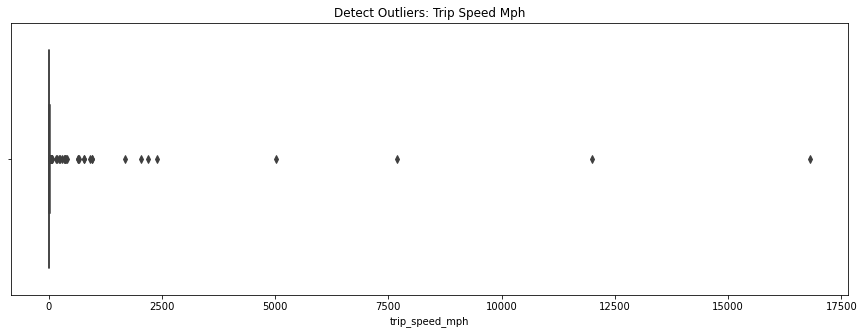

In [52]:
boxplot('trip_speed_mph')

In [53]:
df[df['trip_speed_mph'] > 65]

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,tip_amount,tolls_amount,total_amount,month,day,hour,time_of_day,season,duration,pickup_dropoff,mean_distance,mean_duration,tip_percent,trip_speed_mph
1075,1,2017-04-12 20:51:58,2017-04-12 20:52:07,1,2.30,1,N,265,265,3,2.5,0.5,0.00,0.00,3.80,April,Wednesday,20,nighttime,2,0.15,265 265,0.753077,3.411538,0.000,9.200000e+02
2223,1,2017-12-17 20:35:28,2017-12-17 20:35:31,1,10.00,1,N,132,132,3,2.5,0.5,0.00,0.00,3.80,December,Sunday,20,nighttime,1,0.05,132 132,2.255862,3.022414,0.000,1.200000e+04
3551,1,2017-11-11 19:33:32,2017-11-11 19:33:47,1,1.50,1,N,233,233,1,15.0,0.0,1.00,0.00,16.80,November,Saturday,19,pm_rush,4,0.25,233 233,0.558571,3.802857,0.063,3.600000e+02
3582,1,2017-01-01 23:53:01,2017-01-01 23:53:42,1,7.30,5,N,1,1,1,62.5,0.0,0.00,0.00,152.30,January,Sunday,23,nighttime,1,0.68,1 1,2.433333,0.463333,0.000,6.441176e+02
3734,1,2017-02-20 16:58:03,2017-02-20 16:58:15,1,0.60,1,N,265,265,3,2.5,0.0,0.00,0.00,3.30,February,Monday,16,pm_rush,1,0.20,265 265,0.753077,3.411538,0.000,1.800000e+02
4319,1,2017-01-28 12:30:33,2017-01-28 12:31:38,1,1.30,1,N,249,249,3,3.0,0.0,0.00,0.00,3.80,January,Saturday,12,daytime,1,1.08,249 249,0.410000,2.556667,0.000,7.222222e+01
5678,1,2017-06-11 04:31:36,2017-06-11 04:31:51,1,1.50,1,N,162,170,2,2.5,0.5,0.00,0.00,3.80,June,Sunday,4,nighttime,3,0.25,162 170,0.804792,5.778542,0.000,3.600000e+02
6501,1,2017-01-22 04:35:37,2017-01-22 04:35:45,1,1.70,2,N,113,113,3,52.0,0.0,0.00,0.00,52.80,January,Sunday,4,nighttime,1,0.13,113 113,0.834615,5.344615,0.000,7.846154e+02
6708,2,2017-10-30 11:23:46,2017-10-30 11:23:49,1,0.32,5,N,264,83,1,62.5,0.0,17.15,0.00,126.00,October,Monday,11,daytime,4,0.05,264 83,0.320000,0.050000,0.158,3.840000e+02
7167,2,2017-03-07 16:42:46,2017-03-07 16:42:48,1,0.20,2,N,264,132,1,52.0,4.5,17.15,0.00,74.49,March,Tuesday,16,pm_rush,2,0.03,264 132,0.066667,0.093333,0.299,4.000000e+02


Based on my [research](https://ekjlaw.com/speed-limits-in-new-york-how-much-over-the-speed-limit-is-too-much/#:~:text=Residential%20Areas%3A%20Usually%2030%20MPH,30%20MPH%20in%20most%20cases.), the maximum speed limit for vehicles in New York City is set at 65 MPH. Upon visual inspection of the boxplot depicting trip speeds, it became evident that there are several instances where the recorded speeds surpass this established limit. Upon further scrutiny, it was observed that these high-speed trips typically span within a very short duration, approximately 2 minutes. Given that these entries deviate significantly from the expected norms and may indicate errors or anomalies in the data, a decision has been made to remove these specific entries from our dataset.

In [54]:
df = df[df['trip_speed_mph'] <= 65]

**Acknowledgments**

This project is inspired by the [Google Advanced Data Analytics Professional Certificate](https://www.coursera.org/professional-certificates/google-advanced-data-analytics) program, specifically the end-of-course portfolio project titled *Automatidata*.

This project utilises a subset of the [2017 Yellow Taxi Trip Data](https://data.cityofnewyork.us/Transportation/2017-Yellow-Taxi-Trip-Data/biws-g3hs) obtained from the New York City Taxi & Limousine Commission, originally published as part of the NYC Open Data program. The dataset, containing 22,699 rows representing different trips and 18 columns, was provided by the Google Advanced Data Analytics Professional Certificate program for the purpose of the end-of-course portfolio project. Invaluable insights into the dataset's attributes and their meanings were derived from the detailed [Data Dictionary](https://data.cityofnewyork.us/api/views/biws-g3hs/files/eb3ccc47-317f-4b2a-8f49-5a684b0b1ecc?download=true&filename=data_dictionary_trip_records_yellow.pdf) provided by the New York City Taxi & Limousine Commission. We acknowledge the contribution of both the NYC TLC and the Google program to the dataset used in this analysis.